In [1]:
from sklearn import tree

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd

In [3]:
n_classes = 2 # We are predicting two different classes PASS and RUSH
clf = tree.DecisionTreeClassifier()

In [4]:
import pyodbc
sql_conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=localhost\\uni;DATABASE=NFL_Prediction;Trusted_Connection=yes')
query = """
SELECT 
      [FieldZoneID]
      ,[PlayTypeID]
      ,[ConditionTypeID]
      ,[SpeedID]
      ,[StadiumID]
      ,surf.[SurfaceTypeID]
      ,[Shotgun]
      ,[AtHome]
      ,[QBisRookie]
      ,[Down]
      ,CASE
            WHEN yardsToGo < 11 THEN 1
            WHEN yardsToGo < 15 THEN 2
            WHEN yardsToGo < 20 THEN 3
            WHEN yardsToGo < 30 THEN 4
            ELSE 5
       END as yardsToGoBucket
      ,[TimeoutsLeft]
      ,qsb.SecondsBucketID as SecondsInQuarterBucketID
      ,[SecondsLeftInQuarter]/60 as [MinutesLeftInQuarter]
      ,hsb.SecondsBucketID as SecondsInHalfBucketID
      ,gsb.SecondsBucketID as SecondsInGameBucketID
      ,[GameQuarter]
      ,opb.PointsBucketID as OffensePointsBucketID
      ,dpb.PointsBucketID as DefensePointsBucketID
      ,pdb.PointsBucketID as PointsDifferenceBucketID
      ,p.OffenseWinLossRatio
      ,p.DefenseWinLossRatio
  FROM [NFL_Prediction].[nfl].[f_play] p
  INNER JOIN [NFL_Prediction].[nfl].[d_team] o on p.OffenseID = o.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_team] d on p.DefenceID = d.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_weather] w on p.WeatherID = w.WeatherID
  INNER JOIN [NFL_Prediction].[nfl].[d_surface] surf on p.SurfaceID = surf.SurfaceID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] qsb on p.SecondsLeftInQuarterBucketID = qsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] hsb on p.SecondsLeftInHalfBucketID = hsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] gsb on p.SecondsLeftInHalfBucketID = gsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] opb on p.OffensePointsBucketID = opb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] dpb on p.DefensePointsBucketID = dpb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] pdb on p.PointsDifferenceBucketID = pdb.PointsBucketID
  where MainPlayerID is not null
"""
df = pd.read_sql(query, sql_conn)
df.head(3)

,FieldZoneID,PlayTypeID,ConditionTypeID,SpeedID,StadiumID,SurfaceTypeID,Shotgun,AtHome,QBisRookie,Down,...,SecondsInQuarterBucketID,MinutesLeftInQuarter,SecondsInHalfBucketID,SecondsInGameBucketID,GameQuarter,OffensePointsBucketID,DefensePointsBucketID,PointsDifferenceBucketID,OffenseWinLossRatio,DefenseWinLossRatio
0,3,1,6,2,61,1,False,True,False,2,...,2,8,5,5,3,6,7,4,0,0
1,1,1,6,2,61,1,False,False,False,1,...,2,7,5,5,3,7,6,7,0,0
2,1,1,6,2,61,1,False,False,False,2,...,2,7,5,5,3,7,6,7,0,0


In [5]:
# drop the prediction column
play_df = df.drop(['PlayTypeID'], axis=1)
play_df.head(3)

,FieldZoneID,ConditionTypeID,SpeedID,StadiumID,SurfaceTypeID,Shotgun,AtHome,QBisRookie,Down,yardsToGoBucket,...,SecondsInQuarterBucketID,MinutesLeftInQuarter,SecondsInHalfBucketID,SecondsInGameBucketID,GameQuarter,OffensePointsBucketID,DefensePointsBucketID,PointsDifferenceBucketID,OffenseWinLossRatio,DefenseWinLossRatio
0,3,6,2,61,1,False,True,False,2,1,...,2,8,5,5,3,6,7,4,0,0
1,1,6,2,61,1,False,False,False,1,1,...,2,7,5,5,3,7,6,7,0,0
2,1,6,2,61,1,False,False,False,2,1,...,2,7,5,5,3,7,6,7,0,0


In [6]:
# Split out the prediction column into separate dataframe
predict_df = df.filter(['PlayTypeID'], axis=1)
predict_df.head(3)

,PlayTypeID
0,1
1,1
2,1


In [7]:
n_trees = 1000
rf = RandomForestClassifier(n_trees)
from sklearn.model_selection import train_test_split
from sklearn import metrics
play_train, play_test, predict_train, predict_test = train_test_split(play_df, predict_df, test_size=0.3, random_state=0)
rf.fit(play_train, predict_train)

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), play_train.columns),
             reverse=True))

Features sorted by their score:
[(0.13, 'StadiumID'), (0.12, 'OffenseWinLossRatio'), (0.11, 'DefenseWinLossRatio'), (0.09, 'Shotgun'), (0.09, 'MinutesLeftInQuarter'), (0.06, 'FieldZoneID'), (0.06, 'Down'), (0.04, 'SpeedID'), (0.04, 'PointsDifferenceBucketID'), (0.03, 'TimeoutsLeft'), (0.03, 'QBisRookie'), (0.02, 'yardsToGoBucket'), (0.02, 'SurfaceTypeID'), (0.02, 'OffensePointsBucketID'), (0.02, 'GameQuarter'), (0.02, 'DefensePointsBucketID'), (0.02, 'ConditionTypeID'), (0.02, 'AtHome'), (0.01, 'SecondsInQuarterBucketID'), (0.01, 'SecondsInHalfBucketID'), (0.01, 'SecondsInGameBucketID')]


C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


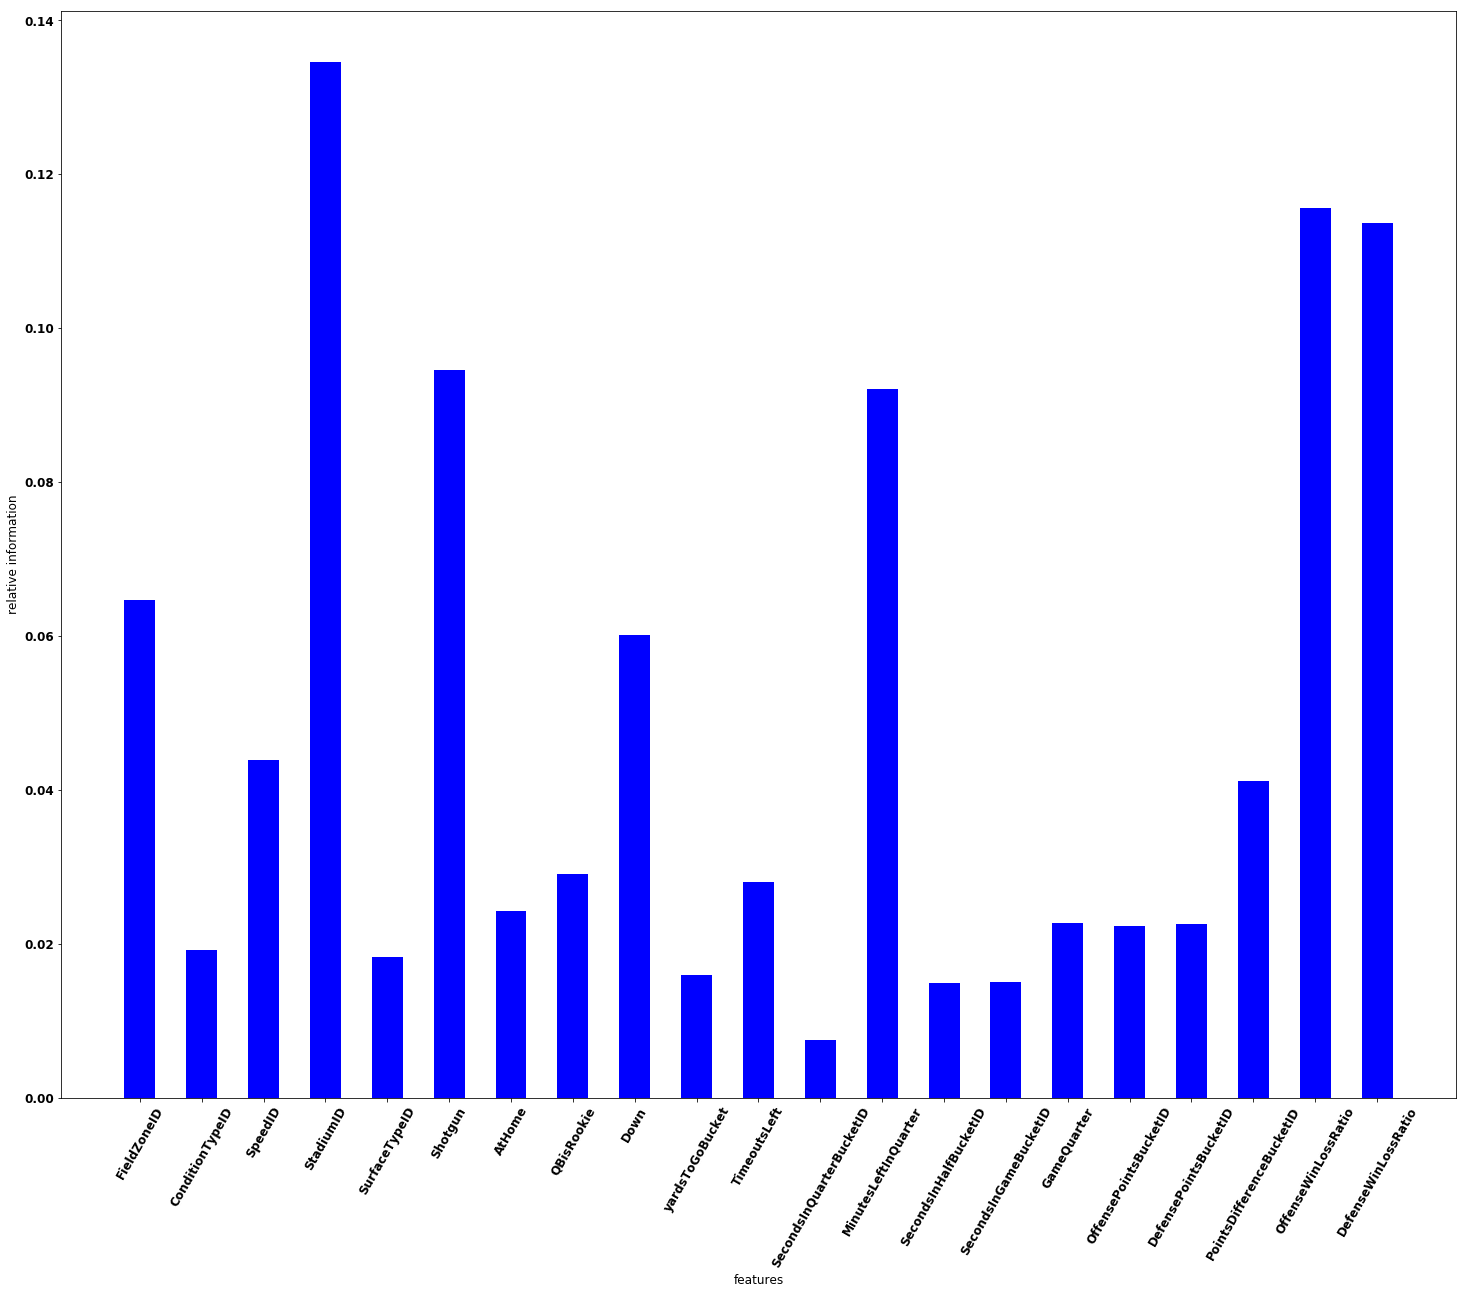

In [9]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
plt_x = numpy.linspace(0,len(play_train.columns)-1,len(play_train.columns))
plt.figure(figsize=(25,20))

plt.bar(plt_x, rf.feature_importances_, width=0.5, color="blue",align='center')
plt.gca().set_xticklabels(plt_x, rotation=60 )
plt.xticks(plt_x, play_train.columns)
plt.ylabel("relative information")
plt.xlabel("features")
plt.show()

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\tj610\Anacon

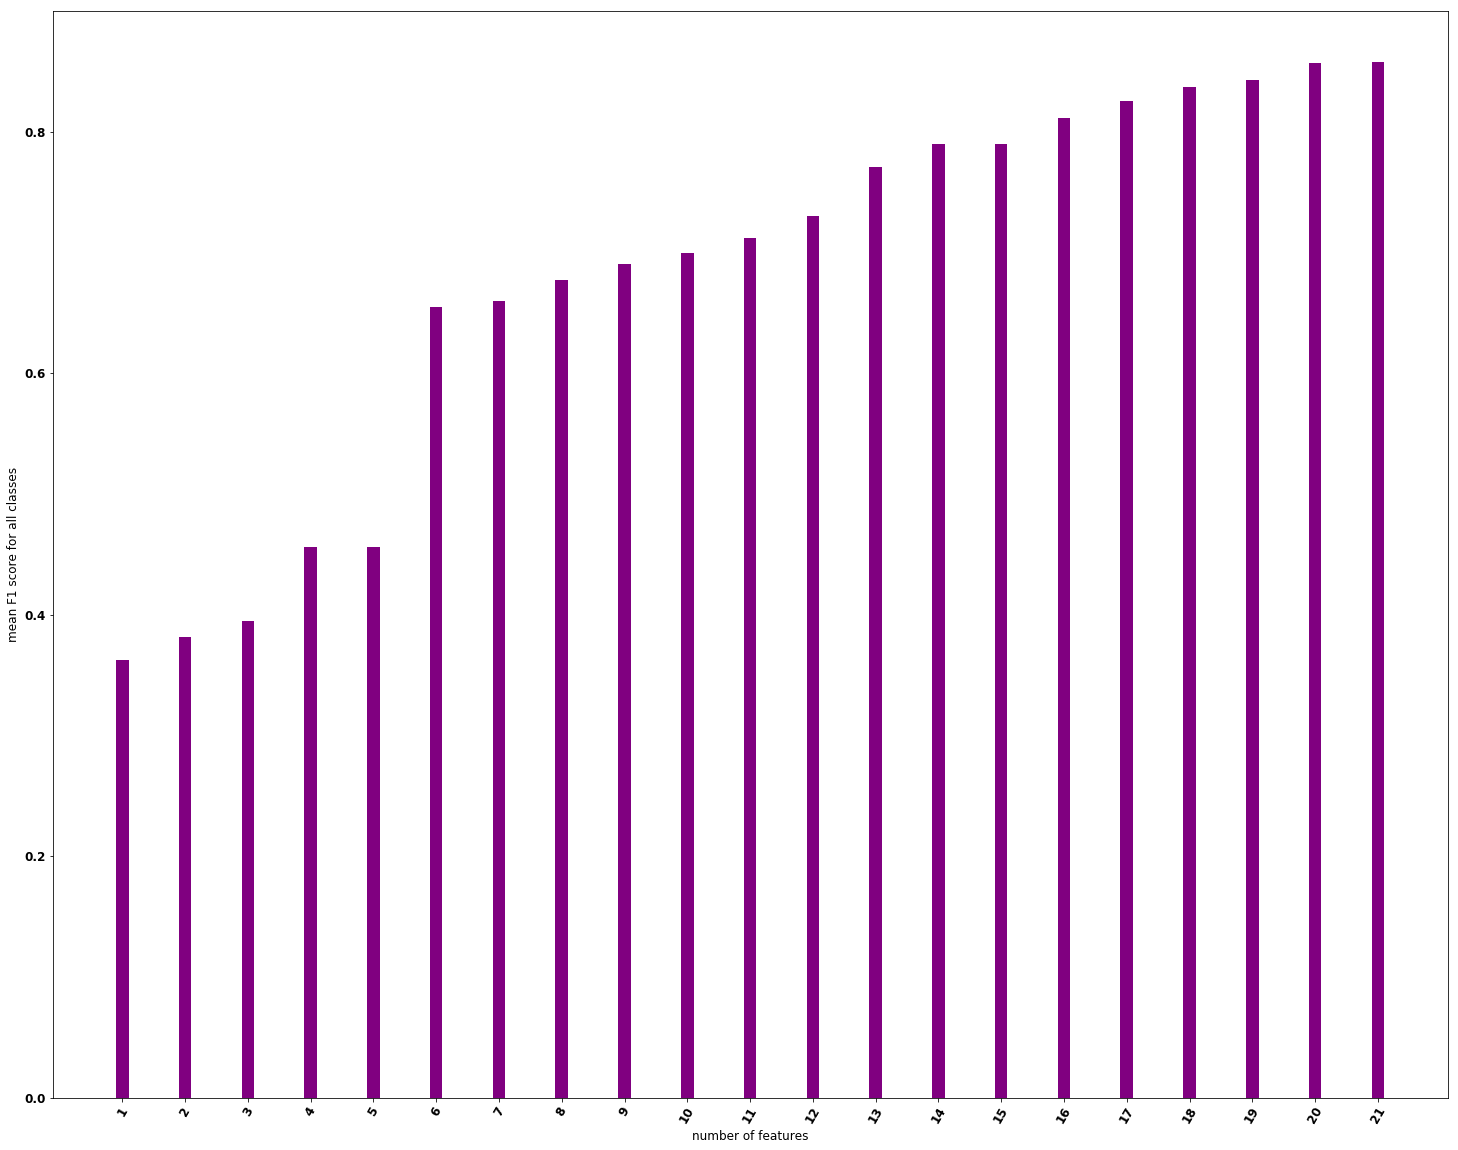

In [10]:
### F1-score sweep over features
F1 = []
plt_x = numpy.linspace(0,len(play_train.columns)-1,len(play_train.columns))
n_trees = 1 # set n_trees to a limiting small number to find out features' effect on constrained models
for i in range(len(play_train.columns)):
    rf = RandomForestClassifier(n_trees, max_features = i+1)
    rf.fit(play_train.iloc[:,:i+1], predict_train)
    Y_pred = rf.predict(play_train.iloc[:,:i+1])
    F1.append(numpy.mean(f1_score(predict_train,Y_pred, average  = None)))
plt.figure(figsize=(25,20))

plt.bar(plt_x, F1, width=0.2, color="purple",align='center')

plt.gca().set_xticklabels(plt_x, rotation=60 )
plt.xticks(plt_x, [ int(x+1) for x in plt_x ])

plt.ylabel("mean F1 score for all classes")
plt.xlabel("number of features")

plt.show()

In [11]:
n_trees = 1000
rf = RandomForestClassifier(n_trees)
from sklearn.model_selection import train_test_split
from sklearn import metrics
play_train, play_test, predict_train, predict_test = train_test_split(play_df, predict_df, test_size=0.3, random_state=0)
rf.fit(play_train, predict_train)

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
from sklearn.metrics import confusion_matrix

play_predict = rf.predict(play_test)

[[79513 29778]
 [29741 52943]]


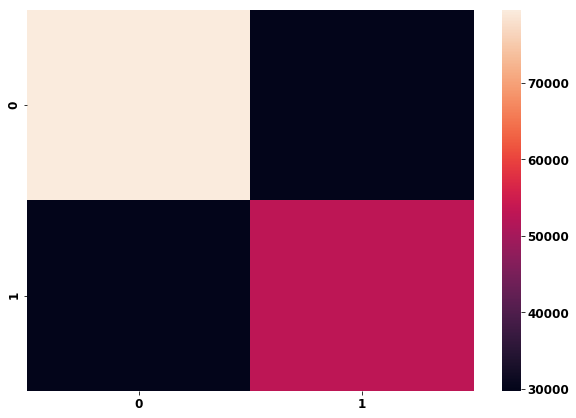

In [13]:
confusion_matrix = confusion_matrix(predict_test, play_predict)
print(confusion_matrix)

import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix, annot=False)

The result is telling us that we have 79635+52943 correct predictions (132,578) and 29741 + 29778 incorrect predictions (59,519) which gives an accuracy of 69.016%

In [14]:
from sklearn.metrics import classification_report
print(classification_report(predict_test, play_predict))

              precision    recall  f1-score   support

           1       0.73      0.73      0.73    109291
           2       0.64      0.64      0.64     82684

    accuracy                           0.69    191975
   macro avg       0.68      0.68      0.68    191975
weighted avg       0.69      0.69      0.69    191975



In [15]:
rf_probs = rf.predict_proba(play_test)[:,1]
rf_probs

array([0.41713333, 0.2625    , 0.07733333, ..., 0.69925   , 0.322     ,
       0.187     ])

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


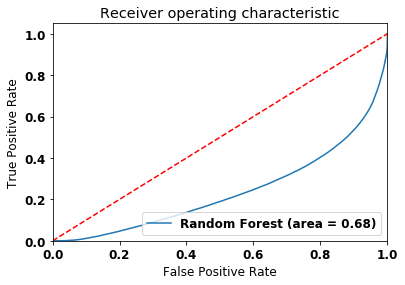

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc = roc_auc_score(predict_test, play_predict)
fpr, tpr, thresholds = roc_curve(predict_test, rf_probs, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [17]:
train_rf_predictions = rf.predict(play_train)
train_rf_probs = rf.predict_proba(play_train)[:, 1]

In [18]:
from sklearn.metrics import precision_score, recall_score
baseline = {}

baseline['recall'] = recall_score(predict_test, 
                                 [1 for _ in range(len(predict_test))])
baseline['precision'] = precision_score(predict_test, 
                                  [1 for _ in range(len(predict_test))])
baseline['roc'] = 0.5

results = {}

results['recall'] = recall_score(predict_test, play_predict)
results['precision'] = precision_score(predict_test, play_predict)
results['roc'] = roc_auc_score(predict_test, rf_probs)

train_results = {}
train_results['recall'] = recall_score(predict_train, train_rf_predictions)
train_results['precision'] = precision_score(predict_train, train_rf_predictions)
train_results['roc'] = roc_auc_score(predict_train, train_rf_probs)

for metric in ['recall', 'precision', 'roc']:
    print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

Recall Baseline: 1.0 Test: 0.73 Train: 1.0
Precision Baseline: 0.57 Test: 0.73 Train: 1.0
Roc Baseline: 0.5 Test: 0.76 Train: 1.0


In [19]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(play_train.columns),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi

,feature,importance
3,StadiumID,0.134500
19,OffenseWinLossRatio,0.115672
20,DefenseWinLossRatio,0.113865
5,Shotgun,0.093727
12,MinutesLeftInQuarter,0.092114
0,FieldZoneID,0.064764
8,Down,0.059765
2,SpeedID,0.043908
18,PointsDifferenceBucketID,0.041337
7,QBisRookie,0.029323


In [20]:
import numpy as np
n_nodes = []
max_depths = []
for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 253131
Average maximum depth 51


In [21]:
from sklearn.tree import export_graphviz

In [22]:
estimator = rf.estimators_[5]
export_graphviz(estimator, 
                out_file='C:\\Users\\tj610\\OneDrive\\Documents\\Uni\\Disertation\\output\\tree.dot', 
                feature_names = play_train.columns.values.tolist(),
                class_names = ['1','2'],
                rounded = True,
                proportion = False,
                precision = 2,
                filled = False)